In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import pandas as pd
import scipy.io
import matplotlib.pylab as pl


In [2]:
micapipe_dir = '../sourcedata/Micapipe_MICs'
ieeg_dir = '../sourcedata/iEEG-BIDS' #(no ses)
ieeg_local = '../sourcedata/iEEG-local/'
hippunfold_dir = '../MICs_v1.3.0/hippunfold'
sub = glob.glob(ieeg_dir + '/sub-PX???')
for i in range(len(sub)): sub[i] = sub[i].split('/')[-1]
ses = 'ses-01'
hemi = ['L','R']
label = ['hipp','dentate'] 
ind = [range(7262), range(7262,7262+1788)]

In [3]:
bp = scipy.io.loadmat(f'{iEEG_local}/Frauscher-wakefullnes.mat')
bp['ChannelPosition'].shape

(1772, 3)

In [4]:
bp['Data'].shape

(13600, 1772)

In [5]:
freq = 200 #Hz
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_lims = [[0.5,4], [4,8], [8,13], [13,30], [30,80]]

def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [6]:
totbp = np.zeros(( bp['Data'].shape[1], len(bands)))
for b in range(len(bands)):
    for c in range(bp['Data'].shape[1]):
        totbp[c,b] = bandpower(bp['Data'][:,c],freq,band_lims[b][0],band_lims[b][1])

In [8]:
threshold_bp = np.nanmedian(totbp,axis=0) + (np.nanstd(totbp,axis=0)*3)
threshold_bp

array([2429.23733237, 1908.76154498, 2007.97502367, 1256.02634301,
        187.15411327])

/tmp/ipykernel_40236/826348525.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


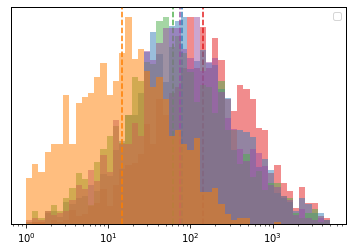

In [9]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = totbp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

In [13]:
# register each patient to MNI152, apply to hippocampal surfaces, and then average hippocampal surfaces
vertices = np.ones([7262+1788,3,2,len(sub)])*np.nan

for s in range(len(sub)):
    cmd2 = f'singularity exec /data/mica3/opt/singularity/hippunfold_v1.2.0.sif c3d_affine_tool '\
        f'-itk {micapipe_dir}/{sub[s]}/ses-01/xfm/{sub[s]}_{ses}_from-nativepro_brain_to-MNI152_0.8mm_mode-image_desc-SyN_0GenericAffine.mat '\
        f'-inv '\
        f'-o {ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-MNI152_desc-deform_0GenericAffine.txt'
    if not glob.glob(f'{ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-MNI152_desc-deform_0GenericAffine.txt'):
        !{cmd2}
    for h in range(len(hemi)):
        for l in range(len(label)):    
            cmd3 = f'wb_command -surface-apply-affine '\
            f'{hippunfold_dir}/{sub[s]}/{ses}/surf/{sub[s]}_{ses}_hemi-{hemi[h]}_space-T1w_den-0p5mm_label-{label[l]}_midthickness.surf.gii '\
            f'{ieeg_dir}/{sub[s]}/xfms/{sub[s]}_{ses}_space-nativepro-to-MNI152_desc-deform_0GenericAffine.txt '\
            f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-MNI152-AFF_den-0p5mm_label-{label[l]}_midthickness.surf.gii'
            if not glob.glob(f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-MNI152-AFF_den-0p5mm_label-{label[l]}_midthickness.surf.gii'):
                !{cmd3}
            cmd4 = f'wb_command -surface-apply-warpfield '\
            f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-MNI152-AFF_den-0p5mm_label-{label[l]}_midthickness.surf.gii'
            f'{micapipe_dir}/{sub[s]}/xfms/{sub[s]}_{ses}from-nativepro_brain_to-MNI152_0.8mm_mode-Image_desc-SyN_1InverseWarp.nii.gz '\
            f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-MNI152_den-0p5mm_label-{label[l]}_midthickness.surf.gii'
            if not glob.glob(f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-MNI152_den-0p5mm_label-{label[l]}_midthickness.surf.gii'):
                !{cmd3}
                
            surf = nib.load(f'{ieeg_dir}/{sub[s]}/tmp/{sub[s]}_{ses}_hemi-{hemi[h]}_space-implant_den-0p5mm_label-{label[l]}_midthickness.surf.gii')
            vertices[ind[l],:,h,s] = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
            
vertices = np.nanmean(vertices,axis=3)

In [14]:
dist_threshold = 5 #mm
hipp_dat_count = np.zeros([7262+1788])
hipp_dat = np.ones([7262+1788,2,5,len(bp['ChannelPosition'])])*np.nan

for h in range(len(hemi)):
    for i in range(len(bp['ChannelPosition'])):
        for v in range(len(vertices)):
            dist = np.linalg.norm(bp['ChannelPosition'][i]-vertices[v,:,h])
            if dist <= dist_threshold:
                hipp_dat[v,h,:,i] = totbp[i,:]
                hipp_dat_count[v] += 1

In [15]:
# remove outliers
# for b in range(5):
#     dat = hipp_dat[:,:,b,:]
#     dat[dat>threshold_bp[b]] = np.nan
#     hipp_dat[:,:,b,:] = dat
# hipp_dat.shape

(9050, 2, 5, 1772)

In [16]:
np.save('../checkpoints/iEEG_Frauscher.npy', [totbp,hipp_dat])

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [17]:
totbp,hipp_dat = np.load('../checkpoints/iEEG_Frauscher.npy', allow_pickle=True)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


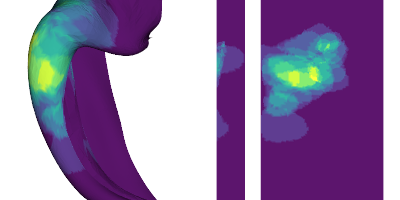

In [18]:
hipp_dat_count = np.sum(~np.isnan(hipp_dat),axis=(1,3))[:,0]
plotting.surfplot_canonical_foldunfold(hipp_dat_count, den='0p5mm', hemis=['L'], size=[400,200], embed_nb=True)

In [19]:
hipp_dat.shape

(9050, 2, 5, 1772)

/tmp/ipykernel_40236/1113241225.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


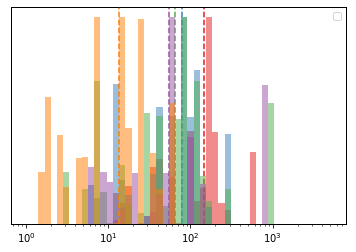

In [20]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = hipp_dat[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

/tmp/ipykernel_40236/134063889.py:1: RuntimeWarning: Mean of empty slice
  plotting.surfplot_canonical_foldunfold(np.nanmean(hipp_dat,axis=(1,3)), hemis=['L'], size=[400,200], embed_nb=True)


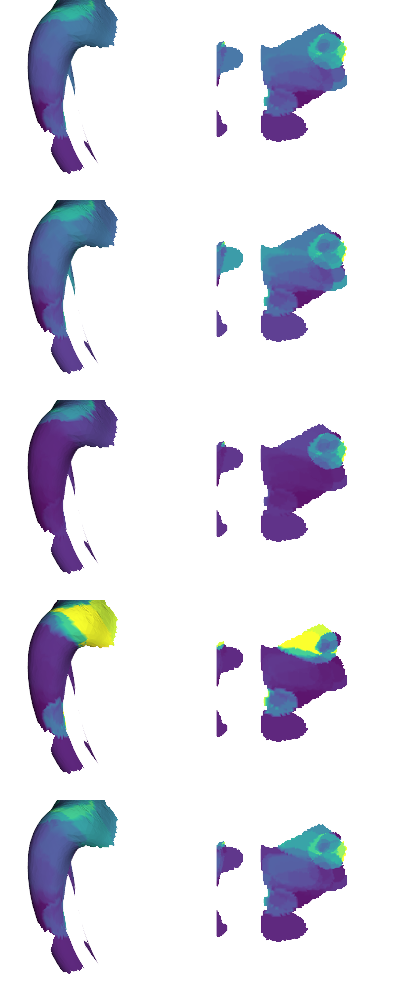

In [21]:
plotting.surfplot_canonical_foldunfold(np.nanmean(hipp_dat,axis=(1,3)), hemis=['L'], size=[400,200], embed_nb=True)

In [22]:
import importlib
importlib.reload(utils)
resorcesdir = '/export03/data/opt/hippunfold_toolbox/resources'
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'{resorcesdir}/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-dentate_midthickness.surf.gii')
vdg = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
fdg = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
F = [f, fdg]

In [23]:
# cominbing BP across channels and vertices for visualization
# here, we exctrapoalte the data from any channel across the entire hippocampus, and then average across all channels. However, the average across channels is weighted by distance to the actual channel contact. 

weights_hipp_dat = np.ones((hipp_dat.shape[0],2,hipp_dat.shape[3]))*np.nan
interp_hipp_dat = np.zeros([hipp_dat.shape[0],5])

for h in range(2):
    for l in range(2):
        for c in range(hipp_dat.shape[3]):
            dat = hipp_dat[:,h,0,c]
            mask = ~np.isnan(dat[ind[l]])
            if np.any(mask):
                sd = utils.surf_dist(mask, F[l])
                weights_hipp_dat[ind[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_dat, axis=(1,2))
for v in range(weights_hipp_dat.shape[0]):
    for h in range(2):
        for c in range(hipp_dat.shape[3]):
            w = weights_hipp_dat[v,h,c] / totweights[v]
            if w>0:
                for b in range(5):
                    bp_cv = np.nanmean(hipp_dat[:,h,b,c])
                    if bp_cv>0:
                        interp_hipp_dat[v,b] = interp_hipp_dat[v,b] + (w*bp_cv)

/tmp/ipykernel_40236/1902236480.py:22: RuntimeWarning: Mean of empty slice
  bp_cv = np.nanmean(hipp_dat[:,h,b,c])


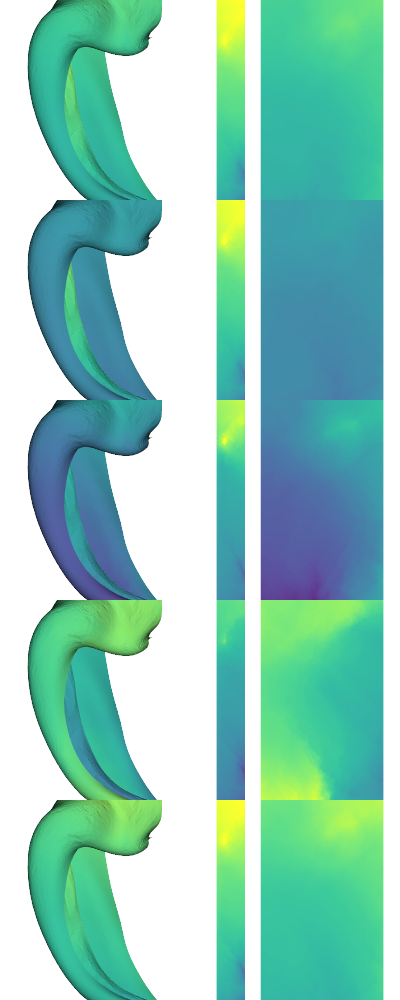

In [24]:
plotting.surfplot_canonical_foldunfold(interp_hipp_dat, den='0p5mm', hemis=['L'], size=[400,200], embed_nb=True)

In [25]:
len(np.where(np.any(~np.isnan(hipp_dat[:,0,0,:]),axis=0))[0])

20

In [26]:
len(np.where(np.any(~np.isnan(hipp_dat[:,1,0,:]),axis=0))[0])

4